In [2]:
import matplotlib.pyplot as plt
import os, json
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
datadir = "./results/"
search_files = [datadir + x for x in os.listdir(datadir) if "search" in x]
upload_files = [datadir + x for x in os.listdir(datadir) if "upload" in x]
gsi_search = [x for x in search_files if "gsi" in x]
weaviate_files = [datadir + x for x in os.listdir(datadir) if "weaviate" in x]
weaviate_search = [x for x in weaviate_files if "search" in x]
weaviate_upload = [x for x in weaviate_files if "upload" in x]
qdrant_files = [datadir + x for x in os.listdir(datadir) if "qdrant" in x]
qdrant_search = [x for x in qdrant_files if "search" in x]
qdrant_upload = [x for x in qdrant_files if "upload" in x]
hnsw_search = [x for x in search_files if "hnswlib" in x and "gxl" not in x]
hnsw_upload = [x for x in upload_files if "hnswlib" in x and "gxl" not in x]
gxl_search = [x for x in search_files if "gxl" in x]
gxl_upload = [x for x in upload_files if "gxl" in x]

## Results

In [4]:
def parse_weav_search(fname):
    # filename parsing
    tmp = fname.split('-')
    if tmp[1] == "gxl":
        if tmp[7].isnumeric():
            m, efc, dataset, dim = int(tmp[3]), int(tmp[5]), tmp[6], int(tmp[7])
        else:
            m, efc, dataset, dim = int(tmp[3]), int(tmp[5]), f"{tmp[6]}-{tmp[7]}", int(tmp[8])
    else:    
        if tmp[6].isnumeric():
            m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), tmp[5], int(tmp[6])
        else:
            m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}", int(tmp[7])
    row = {'vdb': 'weaviate', 'm':m, 'efc': efc, 'dataset': dataset, 'dim': dim}

    # json file parse
    f = open(fname)
    tmp = json.load(f)
    row.update(tmp['params'].pop('vectorIndexConfig'))
    row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [5]:
def parse_gsi_search(fname):
    nbits, dim, dataset, m, efc, ef, new = [None] * 7
    # filename parsing
    tmp = fname.split('-')
    if "new" in fname:
        new = True
    # get nbits, dims, and dataset
    search_type = tmp[2]
    # get hnsw params if available
    if search_type == "hnsw":
        if "-m-" not in fname:
            # set default values
            m, efc, ef = 32, 100, 100
        else:
            # pop 'm' and 'ef' values
            m, efc = tmp.pop(4), tmp.pop(5)
            # remove 'm' and 'ef'
            tmp.pop(3), tmp.pop(3)
    # get dataset and nbits params
    for i, x in enumerate(tmp):
        if x.isnumeric():
            if not nbits:
                nbits = int(x)
            elif not dim:
                dim = int(x)
                if tmp[i-1] == "image":
                    dataset = f"{tmp[i-2]}-{tmp[i-1]}"
                else:
                    dataset = f"{tmp[i-1]}"    
    row = {'vdb': 'gsi', 'search_type': search_type, 'nbits': nbits, 'dataset': dataset, 'dim': dim, 
           'm':m, 'efc': efc, 'ef': ef, 'new': new}
    # json file parse
    f = open(fname)
    tmp = json.load(f)
    # add json file data to row
    if '-m-' in fname:
        row.update(tmp['params'].pop('vectorIndexConfig'))
        row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [6]:
def parse_qdrant_search(fname):
    # filename parsing
    tmp = fname.split('-')
    if "rps" in fname or "mmap" in fname: 
        mode = tmp.pop(1)
    else: 
        mode = 'default'
    if tmp[6].isnumeric():
        m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), tmp[5], int(tmp[6])
    else:
        m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}", int(tmp[7])
    row = {'vdb': 'qdrant', 'm':m, 'efc': efc, 'dataset': dataset, 'dim': dim, 'mode': mode}

    # json file parse
    f = open(fname)
    tmp = json.load(f)
    row.update(tmp['params'].pop('search_params'))
    row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [7]:
# create GSI search results dataframe
columns = ['vdb', 'search_type', 'nbits', 'dataset', 'dim', 'm', 'efc', 'ef', 'new', 'total_time', 'mean_time',\
             'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
             'precisions', 'latencies']
gsi_df = pd.DataFrame(columns=columns)
for fname in gsi_search:
    gsi_df.loc[len(gsi_df), :] = parse_gsi_search(fname)
gsi_df.fillna(np.nan)
gsi_df = gsi_df.astype({'m': float, 'efc': float, 'ef': float, 'dim': int, 'mean_precisions': float, 'mean_time': float})
gsi_df = gsi_df.astype({'m': 'Int64', 'efc': 'Int64', 'ef': 'Int64'})
gsi_df = gsi_df.sort_values(by=['search_type', 'dataset', 'dim', 'nbits']).reset_index(drop=True)
gsi_df.new = gsi_df.new.fillna(False)
gsi_df = gsi_df.astype({'new': 'Int64'})
gsi_df.new[9] = 2

In [8]:
# create weaviate search results dataframe
columns = ['vdb', 'm', 'efc', 'ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time',\
             'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
             'precisions', 'latencies']
weav_df = pd.DataFrame(columns=columns)
for fname in weaviate_search:
    row = parse_weav_search(fname)
    weav_df.loc[len(weav_df)] = row
weav_df = weav_df.sort_values(by=['m', 'efc', 'dim', 'ef']).reset_index(drop=True)
weav_df.parallel.fillna(0, inplace=True)

In [9]:
# create qdrant search results dataframe
columns = ['vdb', 'm', 'efc', 'hnsw_ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time',\
             'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
             'precisions', 'latencies']
qdrant_df = pd.DataFrame(columns=columns)
for fname in qdrant_search:
    qdrant_df.loc[len(qdrant_df)] = parse_qdrant_search(fname)
qdrant_df = qdrant_df.sort_values(by=['m', 'efc', 'dim', 'hnsw_ef']).reset_index(drop=True)

In [10]:
# create hnswlib search results dataframe
hnsw_df = pd.DataFrame(columns=parse_weav_search(hnsw_search[0]).keys())
for fname in hnsw_search:
    row = parse_weav_search(fname)
    hnsw_df.loc[len(hnsw_df), :] = row
hnsw_df.vdb = 'hnswlib'
hnsw_df = hnsw_df.sort_values(['m', 'efc', 'ef', 'parallel']).reset_index(drop=True)
# create gxl search results dataframe
gxl_df = pd.DataFrame(columns=parse_weav_search(gxl_search[0]).keys())
for fname in gxl_search:
    row = parse_weav_search(fname)
    gxl_df.loc[len(gxl_df), :] = row
gxl_df.vdb = 'hnswlib_gxl'
gxl_df = gxl_df.sort_values(['m', 'efc', 'ef']).reset_index(drop=True)

In [11]:
# qdrant_df.to_csv('/mnt/nas1/vdbenchmark-results/qdrant-df.csv')
# weav_df.to_csv('/mnt/nas1/vdbenchmark-results/weaviate-df.csv')
# gsi_df.to_csv('/mnt/nas1/vdbenchmark-results/gsi-df.csv')
# hnsw_df.to_csv('/mnt/nas1/vdbenchmark-results/hnswlib-df.csv')

## Seaborn plots

In [12]:
parallels = [1, 0]
dim = 96

qdrant_copy = qdrant_df.copy()
qdrant_copy = qdrant_copy[(qdrant_copy.dim == dim) & (qdrant_copy.parallel.isin(parallels))]
weav_copy = weav_df.copy()
weav_copy = weav_copy[(weav_copy.dim == dim) & (weav_copy.parallel.isin(parallels))]
hnsw_copy = hnsw_df.copy()
hnsw_copy = hnsw_copy[(hnsw_copy.dim == dim) & (hnsw_copy.parallel.isin(parallels))]
gsi_copy = gsi_df.copy()
gsi_copy = gsi_copy[(gsi_copy.dim == dim)]
gxl_copy = gxl_df.copy()
gxl_copy = gxl_copy[(gxl_copy.dim == dim) & (gxl_copy.parallel.isin(parallels))]

In [13]:
gb = weav_copy.groupby(['efc', 'm', 'ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
weav_copy = gb.reset_index()
gb = qdrant_copy.groupby(['efc', 'm', 'hnsw_ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
qdrant_copy = gb.reset_index()
gb = hnsw_copy.groupby(['efc', 'm', 'ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
hnsw_copy = gb.reset_index()
gb = gxl_copy.groupby(['efc', 'm', 'ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
gxl_copy = gxl_copy.reset_index()

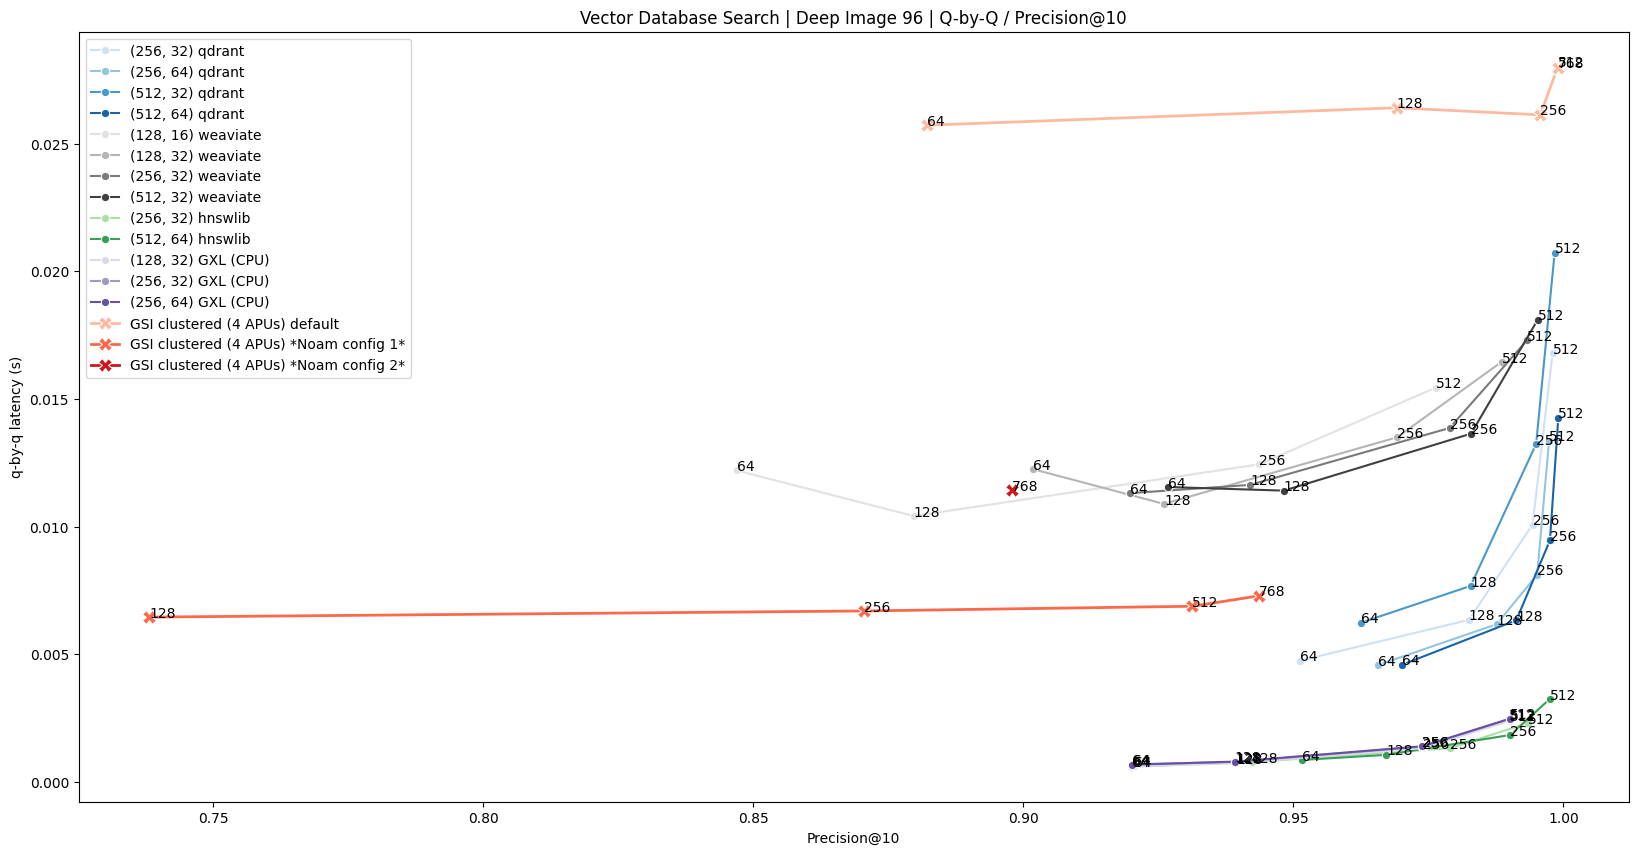

In [15]:
fig, ax = plt.subplots(figsize=(20,10))

qdrant_configs = qdrant_copy.groupby(["efc", "m"]).count().index.to_list()
weav_configs = weav_copy.groupby(["efc", "m"]).count().index.to_list()
hnsw_configs = hnsw_copy.groupby(["efc", "m"]).count().index.to_list()
gxl_configs = gxl_copy.groupby(["efc", "m"]).count().index.to_list()
gsi_configs = gsi_copy.groupby("nbits").count().index.to_list()

ax.set_title("Vector Database Search | Deep Image 96 | Q-by-Q / Precision@10")
ax.set_xlabel("Precision@10")
ax.set_ylabel("q-by-q latency (s)")

palette = sns.color_palette("Blues", len(qdrant_configs))
sns.lineplot(data=qdrant_copy, x="mean_precisions", y="mean_time", hue=qdrant_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
for ef, x, y in zip(qdrant_copy.hnsw_ef, qdrant_copy.mean_precisions, qdrant_copy.mean_time):
    plt.annotate(ef, (x, y))

palette = sns.color_palette("Greys", len(weav_configs))
sns.lineplot(data=weav_copy, x="mean_precisions", y="mean_time", hue=weav_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
for ef, x, y in zip(weav_copy.ef, weav_copy.mean_precisions, weav_copy.mean_time):
    plt.annotate(ef, (x, y))
    
palette = sns.color_palette("Greens", len(hnsw_configs))
sns.lineplot(data=hnsw_copy, x="mean_precisions", y="mean_time", hue=hnsw_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
for ef, x, y in zip(hnsw_copy.ef, hnsw_copy.mean_precisions, hnsw_copy.mean_time):
    plt.annotate(ef, (x,y))
    
palette = sns.color_palette("Purples", len(gxl_configs))
sns.lineplot(data=gxl_copy, x="mean_precisions", y="mean_time", hue=gxl_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
for ef, x, y in zip(gxl_copy.ef, gxl_copy.mean_precisions, gxl_copy.mean_time):
    plt.annotate(ef, (x,y))

palette = sns.color_palette("Reds", len(gsi_copy['new'].unique()))
sns.lineplot(data=gsi_copy, x="mean_precisions", y="mean_time", hue=gsi_copy[["new"]].apply(tuple, axis=1), marker="X", palette=palette, linewidth=2, markersize=10)
for nbits, x, y in zip(gsi_copy.nbits, gsi_copy.mean_precisions, gsi_copy.mean_time):
    plt.annotate(nbits, (x, y))

leg = ax.legend(loc='upper left')
curr = 0
[x.set_text(x.get_text() + ' qdrant') for x in leg.get_texts()[:len(qdrant_configs)]]
curr += len(qdrant_configs)
[x.set_text(x.get_text() + ' weaviate') for x in leg.get_texts()[curr:curr + len(weav_configs)]]
curr += len(weav_configs)
[x.set_text(x.get_text() + ' hnswlib') for x in leg.get_texts()[curr:curr + len(hnsw_configs)]]
curr += len(hnsw_configs)
[x.set_text(x.get_text() + ' GXL (CPU)') for x in leg.get_texts()[curr:curr + len(gxl_configs)]]
[x.set_text('GSI clustered (4 APUs) default') for x in leg.get_texts()[-3:-2]]
[x.set_text('GSI clustered (4 APUs) *Noam config 1*') for x in leg.get_texts()[-2:-1]]
[x.set_text('GSI clustered (4 APUs) *Noam config 2*') for x in leg.get_texts()[-1:]]


fig.show()

## Upload

(32, 128)    216.432673
(32, 256)    227.315809
(64, 256)    226.908862
(64, 512)    226.333258
dtype: object

In [85]:
gxlu = pd.read_json(gxl_upload[0])
row = {}
row.update(gxlu['params']['vectorIndexConfig'])
row.update(gxlu.results[~gxlu.results.isna()].to_dict())
row.pop('ef')
row['dataset'] = None
gxlu = pd.DataFrame(columns=row.keys())
for path in [x for x in gxl_upload if "deep-image" in x]:
    tmp = pd.read_json(path)
    row = {}replace
    row.update(tmp['params']['vectorIndexConfig'])
    row.update(tmp.results[~tmp.results.isna()].to_dict())
    row.pop('ef')
    row['dataset'] = path.split('-')[6]
    gxlu.loc[len(gxlu), :] = row
gxlu.reset_index(drop=True, inplace=True)
gxlu.index = ['gxl\n' + str(x) for x in gxlu.groupby(['maxConnections', 'efConstruction']).count().index.to_list()]
gxlu.drop(['maxConnections', 'efConstruction'], axis = 1, inplace=True)
gxlu['total_time'] = gxlu[['cen_gen', 'knn_gen', 'knn_sym', 'idx_gen']].sum(axis=1)

In [86]:
qdrantu = pd.read_json(qdrant_upload[0])
row = {}
row.update(qdrantu['params']['hnsw_config'])
row.update(qdrantu['results'][~qdrantu['results'].isna()].to_dict())
row.pop('post_upload')
row['dataset'] = None
qdrantu = pd.DataFrame(columns=row.keys())
for path in [x for x in qdrant_upload if "deep-image" in x]:
    tmp = pd.read_json(path)
    row = {}
    row.update(tmp['params']['hnsw_config'])
    row.update(tmp['results'][~tmp['results'].isna()].to_dict())
    row.pop('post_upload')
    row['dataset'] = path.split('-')[5]
    qdrantu.loc[len(qdrantu), :] = row
qdrantu.reset_index(drop=True, inplace=True)
tmp = qdrantu.groupby(['ef_construct', 'm']).count().index.to_list()
qdrantu.index = ['qdrant\n' + str(x) for x in tmp]
qdrantu.drop(['m', 'ef_construct'], axis = 1, inplace=True)

In [87]:
hnswu = pd.read_json(hnsw_upload[0])
row = {}
row.update(hnswu['params']['vectorIndexConfig'])
row.update(hnswu['results'][~hnswu['results'].isna()].to_dict())
row.pop('post_upload')
hnswu = pd.DataFrame(columns=row.keys())
for path in [x for x in hnsw_upload if "deep-image" in x]:
    tmp = pd.read_json(path)
    row = {}
    row.update(tmp['params']['vectorIndexConfig'])
    row.update(tmp['results'][~tmp['results'].isna()].to_dict())
    row['dataset'] = path.split('-')[5]
    hnswu.loc[len(hnswu), :] = row
hnswu.index = ['hnsw\n' + str(x) for x in hnswu.groupby(['efConstruction', 'maxConnections']).count().index.to_list()]
hnswu.drop(['maxConnections', 'efConstruction'], axis=1, inplace=True)

<Axes: xlabel='None', ylabel='total_time'>

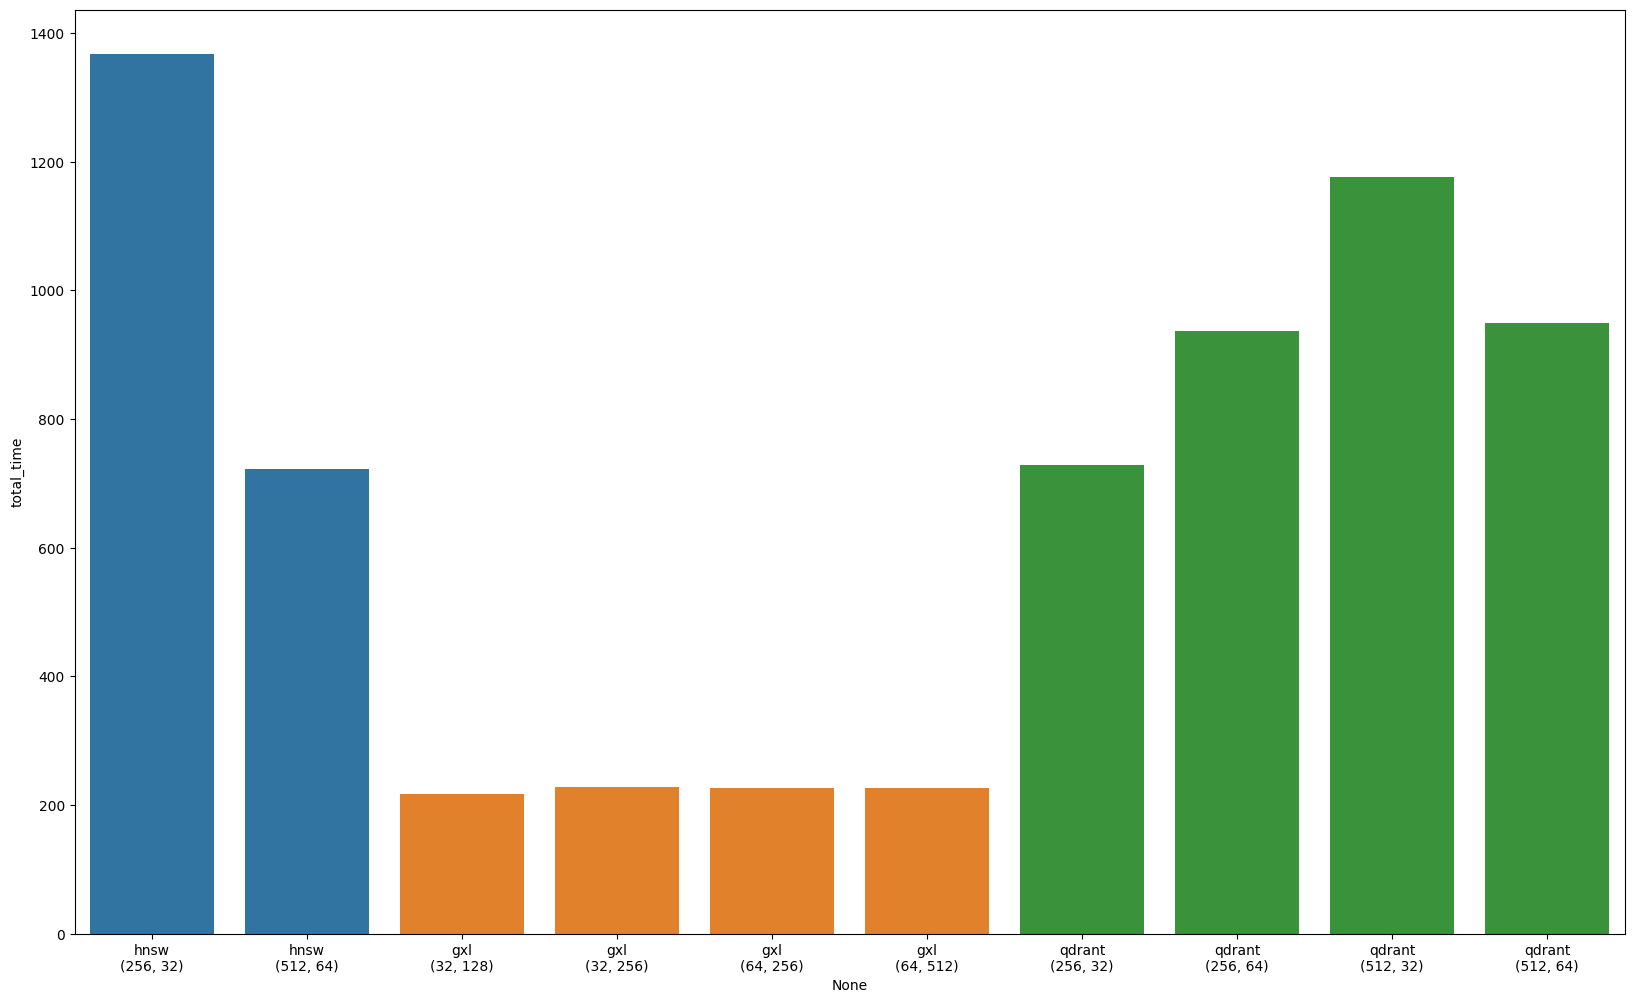

In [94]:
fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(x=hnswu.index, y=hnswu.total_time)
sns.barplot(x=gxlu.index, y=gxlu.total_time)
sns.barplot(x=qdrantu.index, y=qdrantu.total_time)